# Get the data 
- using PyTorch's dataset downloader 
- then create dataloaders to iterate through the 

In [1]:

import torch 
from torchvision import datasets, transforms 

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])

# download datasets 
train_set = datasets.MNIST('data/train', download=True, train=True, transform = transform)
test_set = datasets.MNIST('data/test', download=True, train=False, transform = transform)

# create dataloaders 
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

Extracting data/train/MNIST/raw/train-images-idx3-ubyte.gz to data/train/MNIST/raw


Extracting data/train/MNIST/raw/train-labels-idx1-ubyte.gz to data/train/MNIST/raw


Extracting data/train/MNIST/raw/t10k-images-idx3-ubyte.gz to data/train/MNIST/raw


Extracting data/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/train/MNIST/raw
Processing...
Done!




/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Extracting data/test/MNIST/raw/train-images-idx3-ubyte.gz to data/test/MNIST/raw


Extracting data/test/MNIST/raw/train-labels-idx1-ubyte.gz to data/test/MNIST/raw


Extracting data/test/MNIST/raw/t10k-images-idx3-ubyte.gz to data/test/MNIST/raw


Extracting data/test/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/test/MNIST/raw
Processing...
Done!








# Visualize our data  

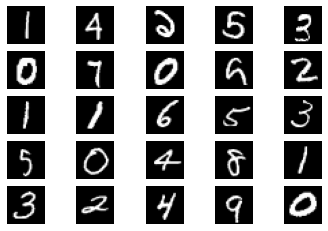

In [2]:
import matplotlib.pyplot as plt
import numpy as np 

dataiter = iter(train_loader)
image, label = dataiter.next() 

#create 5x5 grid of images 
tot_imgs = 25
plt.figure() 
for idx in range(1, tot_imgs+1): 
    plt.subplot(5, 5, idx)
    plt.axis('off')
    plt.imshow(image[idx].numpy().squeeze(), cmap='gray')

# Build our Neural Network

In [0]:
import torch.nn as nn 
import torch.nn.functional as F 

class CNN(nn.Module): 
    def __init__(self): 
        super(CNN,self).__init__()

        self.conv_net = nn.Sequential( 
            # Conv Block 1
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1), 
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Block 2 
            nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.ReLU(inplace=True)
        )

        self.fc = nn.Sequential( 
            nn.Linear(in_features=4*4*50, out_features=500), 
            nn.ReLU(inplace=True),
            nn.Linear(in_features=500, out_features=10)
        )   

    def forward(self, x): 
        x = self.conv_net(x) 
        x = x.view(-1, 4*4*50)
        x = self.fc(x) 
        return F.log_softmax(x, dim=1)

# Train my model 
- First instantiate model, loss function, and optimizer
   - Choose your learning rate alpha! 
   - Define what device to use 
- Create training function  

In [0]:
import torch.optim as optim 
# modify this! 
alpha = .001 # learning rates 

model = CNN() 
criterion = nn.NLLLoss() 
optimizer = optim.Adam(model.parameters(), lr = alpha)

# define what device to use to train model 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
log_interval = 64
def train(model, criterion, optimizer, num_epochs=3): 
    model.train()
    for epoch in range(1, num_epochs+1): 
        avg_loss = 0 
        for batch_idx, (images, target) in enumerate(train_loader):
            # send data to the device 
            images, target = images.to(device), target.to(device) 
            
            optimizer.zero_grad()
            output = model(images) 
            loss = criterion(output, target)
            loss.backward() 
            optimizer.step() # backpropogation update step 
            avg_loss += loss.item() 

            # Save model during training incase failure 
            torch.save(model.state_dict(), 'cnn.th')
            
            if batch_idx % log_interval == 0: 
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(images), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        avg_loss /= len(train_loader.dataset)
    return avg_loss

train(model, criterion, optimizer, num_epochs=4)

# Test my model on validation set
- And also visualize the predictions 

In [0]:
def test(): 
    model.eval()
    test_loss = 0 
    num_correct_preds = 0 
    with torch.no_grad(): 
        for i, (data, target) in enumerate(test_loader):  
            output = model(data)
            predictions = (output.argmax(dim=1, keepdim=False)) # get the index of the max log-probability
            loss = criterion(output, target)
            num_correct_preds += predictions.eq(target.view_as(predictions)).sum().item()

            test_loss += loss.item()
        
            avg_loss = test_loss/len(test_loader.dataset)
            accuracy = 100 * num_correct_preds/len(test_loader.dataset)
            if i % log_interval:
                print('[{}/{} {:.0f}%] Avg.Loss: {} Accuracy: [{}/{} {:.0f}%]'.format(i*len(data), len(test_loader.dataset), 
                   100 * i/len(test_loader),  avg_loss, num_correct_preds, len(test_loader.dataset), accuracy)
                )

test()

[64/10000 1%] Avg.Loss: 6.340861017815769e-06 Accuracy: [126/10000 1%]
[128/10000 1%] Avg.Loss: 6.413179897936061e-06 Accuracy: [190/10000 2%]
[192/10000 2%] Avg.Loss: 1.003130924073048e-05 Accuracy: [253/10000 3%]
[256/10000 3%] Avg.Loss: 1.0122218891046941e-05 Accuracy: [317/10000 3%]
[320/10000 3%] Avg.Loss: 1.3392488448880612e-05 Accuracy: [380/10000 4%]
[384/10000 4%] Avg.Loss: 1.440708942245692e-05 Accuracy: [444/10000 4%]
[448/10000 4%] Avg.Loss: 1.9799875910393893e-05 Accuracy: [506/10000 5%]
[512/10000 5%] Avg.Loss: 2.166328940074891e-05 Accuracy: [569/10000 6%]
[576/10000 6%] Avg.Loss: 2.231028729584068e-05 Accuracy: [633/10000 6%]
[640/10000 6%] Avg.Loss: 2.4976921244524418e-05 Accuracy: [696/10000 7%]
[704/10000 7%] Avg.Loss: 2.8380967467091976e-05 Accuracy: [758/10000 8%]
[768/10000 8%] Avg.Loss: 2.948150697629899e-05 Accuracy: [822/10000 8%]
[832/10000 8%] Avg.Loss: 3.177323534619063e-05 Accuracy: [885/10000 9%]
[896/10000 9%] Avg.Loss: 3.1859416351653635e-05 Accuracy: [9